Projet kaggle : Tweet Sentiment Extraction

Emma BEUZE, Nacim BOUIA, Antoine FRANCESCHI, Ayoub RHIM, Guillaume RUSSIAS

In [ ]:
#???
import jax
import jax.numpy as jnp
import gzip
import pickle

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
#besoin d'une version > à 1.2.0
pd.__version__

'1.2.4'

Il y a 4 types de colonnes :


*   textID - unique ID for each piece of text 
*   text - the text of the tweet 
*   sentiment - the general sentiment of the tweet        => il y a 3 sentiments : positive, neutral, negative
*   selected_text - [train only] the text that supports the tweet's sentiment 


**OBJECTIF :  examiner le sentiment donné pour un tweet donné et déterminer le mot ou la phrase qui le soutient le mieux.**






In [3]:
os.chdir( os.getcwd() + "/donnees" )

Page qui résume comment utiliser les pandas : https://ledatascientist.com/manipulez-vos-donnees-avec-pandas/

In [4]:
# Load the dataset
train_set = pd.read_csv(r"train.csv")
test_set = pd.read_csv(r"test.csv")

#print(train_set.shape)    => (27481, 4)  (textID, text, selected_text, sentiment )
#print(test_set.shape)     => (3534, 3)   (textID, text, sentiment)

train_data_text = train_set["text"]
train_data_sentiment = train_set["sentiment"]

N_train = train_data_text.shape[0]

train_data = [(train_data_text[k],train_data_sentiment[k]) for k in range(N_train)]
train_labels = train_set["selected_text"]


# check data makes sense

print("Exemple 1 :",train_data[1], "extrait choisi :", train_labels[1])
print("Exemple 2 :",train_data[59], "extrait choisi :", train_labels[59])
print("Exemple 3 :",train_data[750], "extrait choisi :", train_labels[750])

Exemple 1 : (' Sooo SAD I will miss you here in San Diego!!!', 'negative') extrait choisi : Sooo SAD
Exemple 2 : (' what fun are you speaking of?', 'neutral') extrait choisi : what fun are you speaking of?
Exemple 3 : (' Thanks! Welcome back!', 'positive') extrait choisi : Thanks! Welcome back!


Dans le concours, la métrique à utiliser est le score de Jaccard : </br>
https://en.wikipedia.org/wiki/Jaccard_index </br>
https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50.


In [5]:
def jaccard(str1, str2): 
    try:
        a = set(str1.lower().split()) 
        b = set(str2.lower().split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))
    except:
        print(str1, str2)

In [6]:
def merge(L,i,j):
    """Creates sentences from lists of words."""
    acc = L[i]
    for k in range(i+1,j):
        acc = acc + " " + L[k]
    return acc

def extract_closest_substring(str1, str2):
    """Extracts from str1 closest substring to str2 with respect to Jaccard distance."""
    """ /!\ Not optimal /!\ """
    split1 = str1.split(" ")
    N = len(split1)
    maxa = 0
    stra = str1
    for i in range(N):
        for j in range(i, N+1):
            acc = merge(split1,i,j)
            jacc = jaccard(acc, str2)
            if jacc >= maxa:
                maxa = jacc
                stra = acc
    return stra

str1 = "Dans le concours, la métrique à utiliser est le score de Jaccard"
str2 = "La métrique est l'étude des objets métriques"

print(jaccard(str1,str2))
extract_closest_substring(str2, str1)

0.2


'La métrique est'

On définit une classe qui servira à la première approche de classifieur. L'objectif est de répliquer une méthode du plus proche voisin.

In [7]:
def row_jac(row):
    return jaccard(row.text_x, row.text_y)

def row_extr(row):
    return extract_closest_substring(row.text_y, row.selected_text)

In [8]:
class RetardedClassifier():
    """Use instances as functions to extract text."""
    def __init__(self, n = 2000):
        self._train_plus = None
        self._train_neg = None
        self._depth = n
    
    def fit(self, train_set):
        #positive train examples
        self._train_plus = train_set[train_set.sentiment == "positive"]
        #negative train examples
        self._train_neg = train_set[train_set.sentiment == "negative"]
    
    def sign_run(self,test_frame,sign):
        """Does a branch run"""
        if sign == "neutral":
            #neutral tweets return tweet itself
            aux = test_frame[test_frame.sentiment == sign]
            aux["selected_text"] = aux.text
            return aux.loc[:,["textID", "text", "selected_text", "sentiment"]]
        
        test_frame_plus = test_frame[test_frame.sentiment == sign]
        
        aux = self._train_plus.loc[0:self._depth,:].merge(test_frame_plus, how='cross')
        
        aux2 = aux
        aux2["score"] = aux.apply(row_jac, axis = 1) 
        
        aux3 = aux2.sort_values('score', ascending=False).drop_duplicates(['text_y'])
        
        aux4 = aux3
        aux4["new_extr"] = aux3.apply(row_extr, axis=1)
        aux4 = aux4.loc[:,["textID_y","text_y","new_extr","sentiment_y"]]
        
        aux5 = aux4.rename(columns = {"textID_y":"textID", "text_y":"text", "new_extr":"selected_text", "sentiment_y":"sentiment"})
        
        return aux5
    
    def __call__(self, test_frame):
        """Runs the actual calculation"""
        acc_pos = self.sign_run(test_frame, "positive")
        acc_neg = self.sign_run(test_frame, "negative")
        acc_neu = self.sign_run(test_frame, "neutral")
        
        return pd.concat([acc_pos, acc_neg, acc_neu])

In [9]:
#Examples
R = RetardedClassifier()
R.fit(train_set)
KK = R(test_set)
KK = KK.sort_index()
KK

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,textID,text,selected_text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,Last session of the day http://twitpic.com/67ezh,neutral
8,e64208b4ef,and within a short time of the last clue all ...,and within a short time of the last clue all ...,neutral
9,37bcad24ca,What did you get? My day is alright.. haven`...,What did you get? My day is alright.. haven`...,neutral
11,43b390b336,I checked. We didn`t win,I checked. We didn`t win,neutral
12,69d6b5d93e,.. and you`re on twitter! Did the tavern bore...,.. and you`re on twitter! Did the tavern bore...,neutral
...,...,...,...,...
720266,cce5c4744a,Watching Body of Lies...good film,of,positive
720348,4a680661d5,congrats! Photo of dre?,of,positive
720432,4de0e1bb73,Perfect night. Best month of my life so far!! ...,Best month of,positive
720735,683149f529,well maybe someone will care,well,positive


In [10]:
KK.sort_values("textID").head()

,textID,text,selected_text,sentiment
311267,000b3211af,And ... Happy Mother`s Day to all Moms You s...,Happy,positive
363,000ceaec55,me too.,me too.,neutral
452892,0010bcc0e2,"watching a film, recovering from my operation",operation,positive
128,001617fca4,oh my god!!! i cried so much!!! watch this guy...,oh my god!!! i cried so much!!! watch this guy...,neutral
1816,001e4be1ab,Rachel is going to have lunch at baixa. And ha...,Rachel is going to have lunch at baixa. And ha...,neutral


In [11]:
test_set.sort_values("textID").head()

,textID,text,sentiment
670,000b3211af,And ... Happy Mother`s Day to all Moms You s...,positive
363,000ceaec55,me too.,neutral
2135,0010bcc0e2,"watching a film, recovering from my operation",positive
128,001617fca4,oh my god!!! i cried so much!!! watch this guy...,neutral
1816,001e4be1ab,Rachel is going to have lunch at baixa. And ha...,neutral


On pourrait essayer de faire de l'analyse sémantique ? Peut-être voir s'il y a des mots très récurrents chez les tweets positifs par exemple.

In [12]:
def parser(string):
    try:
        return string.split(" ")
    except:
        pass

axx = train_set
axx["words"] = train_set.selected_text.map(parser)

axx1 = list(axx.words)

In [13]:
import progressbar as pb

pbar = pb.ProgressBar()

def flatten(list_of_lists):
    flat_list = []
    for list in pbar(list_of_lists):
        try:
            flat_list = flat_list + list
        except TypeError:
            pass
    return flat_list

axx2 = flatten(axx1)

100% |########################################################################|


In [14]:
#Most common words and their number of occurences
hist = pd.Series(axx2).value_counts()
hist[1:100].head()

to     5190
I      4842
the    4303
a      3427
my     2503
dtype: int64

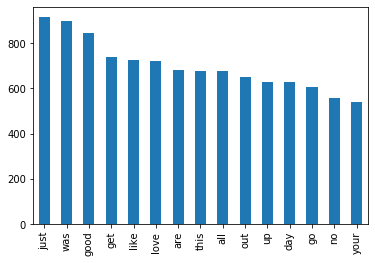

In [15]:
#Histogram plot
hist[25:40].plot(kind = "bar")